###Use Case C - BERT model notebook

###Connect Google Drive

In [2]:
## To read table_of_contents.xml and
## store the model (allowing re-runs starting from re-loading the model)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyodbc

     |████████████████████████████████| 280 kB 7.3 MB/s 
  Created wheel for pyodbc: filename=pyodbc-4.0.32-cp37-cp37m-linux_x86_64.whl size=287342 sha256=f1d856991d700fd469632b57d443128b697ed954d3eb65fc7285c72579a539b7
  Stored in directory: /root/.cache/pip/wheels/2e/9c/da/8652fd42e0f662015554f00a9e96fe4f438dfd1ef59787879e
Successfully built pyodbc


In [4]:
!apt-get install virtuoso-opensource

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libvirtodbc0 virtuoso-opensource-6.1 virtuoso-opensource-6.1-bin
  virtuoso-opensource-6.1-common virtuoso-server virtuoso-vad-conductor
  virtuoso-vsp-startpage
Suggested packages:
  virtuoso-vad-doc virtuoso-vad-demo virtuoso-vad-tutorial
  virtuoso-vad-rdfmappers virtuoso-vad-sparqldemo virtuoso-vad-syncml
  virtuoso-vad-bpel virtuoso-vad-isparql virtuoso-vad-ods virtuoso-vad-dbpedia
  virtuoso-vad-facetedbrowser
The following NEW packages will be installed:
  libvirtodbc0 virtuoso-opensource virtuoso-opensource-6.1
  virtuoso-opensource-6.1-bin virtuoso-opensource-6.1-common virtuoso-server
  virtuoso-vad-conductor virtuoso-vsp-startpage
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,835 kB of archives.
After this operation, 27.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/

In [5]:
!pip install sentence-transformers

     |████████████████████████████████| 78 kB 5.5 MB/s 
     |████████████████████████████████| 3.4 MB 16.7 MB/s 
     |████████████████████████████████| 6.8 MB 55.3 MB/s 
     |████████████████████████████████| 1.2 MB 62.7 MB/s 
     |████████████████████████████████| 67 kB 7.5 MB/s 
     |████████████████████████████████| 895 kB 55.3 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 3.3 MB 56.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=c84f981bb5f13d5a043c6df44120f53f3aa2e73568a5d0f9219b265f90c23d80
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
!pip install eurostat

     |████████████████████████████████| 45 kB 2.4 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15147 sha256=6eb506bd526f1eef75571f4fbc4edb26189764de19772be25555d4054cdee468
  Stored in directory: /root/.cache/pip/wheels/58/88/2a/8d619cf38d7cf939e54b6ccdece05d31b64b3eb419c11d1ed3
Successfully built jsonpath-rw


In [7]:
import gensim
import pandas as pd
import numpy as np
import re
import pyodbc
import nltk, os
import sklearn
import lxml
import lxml.etree
import lxml.html
import ipywidgets as widgets
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import torch
import random

from collections import defaultdict
from sentence_transformers import SentenceTransformer, SentencesDataset
from sentence_transformers.losses import TripletLoss, CosineSimilarityLoss, MultipleNegativesRankingLoss
from sentence_transformers.readers import LabelSentenceReader, InputExample
from torch.utils.data import DataLoader

from pathlib import Path
from google.colab import data_table, drive
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

In [8]:
def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    x = re.sub(r'â.{2}',"'",x) ### !!! NEW: single quotes are read as: âXX
    
    #x = x.encode('latin1').decode('utf-8') ## â\x80\x99
    #x = ud.normalize('NFKD',x).encode('ascii', 'ignore').decode()
    
    return x

def lemmatize_text(text): ## only alphanumeric characters and drop stop-words
    return [lemmatizer.lemmatize(w).lower() for w in w_tokenizer.tokenize(text) if w.isalnum() and not w.lower() in stop
           and not re.match(r'^[0-9]+$',w) and len(w) >=5]


# counts the number of parents to the root element
def get_depth(element):
    depth = 0
    parent = element.getparent()
    while parent is not None:
        depth += 1
        parent = parent.getparent()
    return depth

# when a new element is entered, it replaces the value in the list
# at that level and drops all values to the right
def reduce_by_depth(elements_codes,elements_names):
    count = 0
    crumbs_codes, crumbs_names, numbers, numbered_crumbs = ([],[],[],[])
    crumbs_files = []
    depth = 0
    crumb_c, crumb_n  = (['']*MAX_DEPTH, ['']* MAX_DEPTH)
    numbering = ['']*MAX_DEPTH
    for i in range(len(elements_codes)):
        elem_code, elem_name  = (elements_codes[i], elements_names[i])
        depth = get_depth(elem_code)
        crumb_c[depth], crumb_n[depth] = (elem_code.text, elem_name.text)
        numbering[depth] = str(int(numbering[depth])+1) if numbering[depth] != '' else '1' 
        crumb_c[depth+1:], crumb_n[depth+1:] = (['']*(MAX_DEPTH-depth-1), ['']*(MAX_DEPTH-depth-1))
        numbering[depth+1:] = ['']*(MAX_DEPTH-depth-1)
        if elem_code.text in elements_files:
            count += 1
            #print('*** found: ',count,':',elem_code.text)
            crumbs_files.append(elem_code.text)
        else:
            crumbs_files.append('')
        crumbs_codes.append(';'.join([e for e in crumb_c if e]))
        crumbs_names.append(';'.join([e for e in crumb_n if e]))
        numbers.append('.'.join([e for e in numbering if e]))
        numbered_crumbs.append((numbers[-1],crumbs_codes[-1],crumbs_names[-1], crumbs_files[-1]))
        if numbered_crumbs[-1][3] != '' and not numbered_crumbs[-1][1].endswith(numbered_crumbs[-1][3]):
            print('*** Error!')
    return (crumbs_codes,crumbs_names,numbers,numbered_crumbs,crumbs_files)


def lemmatize_list(x):
    str = ' '.join(x)
    return ' '.join(lemmatize_text(str))



###Path to table_of_contents.xml in Google Drive

In [9]:
# set the path to the xml file (NEED TO SET THE CORRECT PATH!)
XML_PATH = '/content/drive/MyDrive/Data for Use Case C/table_of_contents.xml'

###Select Bi-encoder model

In [10]:
# Load pre-trained model that we will use as a base for fine tuning
# By Default it loads the first in options
# Warning: loading 2nd or 3rd model for finetuning requires large amounts of memory

bi_encoder_model_dropdown = widgets.Dropdown(options=["multi-qa-MiniLM-L6-cos-v1", "multi-qa-distilbert-cos-v1", "multi-qa-mpnet-base-cos-v1"])
display(widgets.HBox([widgets.Label(value="Bi-encoder model:"), bi_encoder_model_dropdown]))

In [11]:
#We use the Bi-Encoder to encode all passages, so that we can use it with semantic search
bi_encoder = SentenceTransformer(bi_encoder_model_dropdown.value)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

###Connect to Virtuoso database

In [12]:
c = pyodbc.connect('DRIVER=/usr/lib/odbc/virtodbc.so;HOST=virtuoso-test.kapcode.fr:1111;UID=kimon;PWD=RkhvQYZ442e2JVXLHdtW;DATABASE=ESTAT')

In [13]:
#set encoding
c.setdecoding(pyodbc.SQL_CHAR, encoding='latin-1')
c.setencoding(encoding="latin-1")

In [14]:
cursor = c.cursor()



### Queries to get SE Glossary articles  

* Definitions from dat_glossary.
* Titles from dat_link_info (with resource_information_id=1, i.e. Eurostat, see ESTAT.V1.mod_resource_information).
* Match above on id.


In [15]:
query = 'SELECT T1.id, T2.title, T1.definition FROM ESTAT.V1.dat_glossary AS T1 INNER JOIN ESTAT.V1.dat_link_info AS T2 ON T1.id=T2.id WHERE T2.resource_information_id=1'
cursor.execute(query)
t1 = cursor.fetchall()
GL_df = pd.DataFrame.from_records(t1, columns=[x[0] for x in cursor.description])
GL_df

,id,title,definition
0,1,Accident at work,An accident at work in the framework ...
1,5,Fatal accident at work,A fatal accident at work refers to an...
2,6,Non-fatal accident at work,A non-fatal accident at work is...
3,8,Aggregate demand,Aggregate demand is the total amount of ...
4,9,Goods and services account,The goods and services account shows ...
...,...,...,...
1309,2319,Actual individual consumption (AIC),"Actual individual consumption , abbrevia..."
1310,2321,Activity rate,Activity rate is the percentage of a...
1311,2322,Activation policies,The activation policies are policies ...
1312,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a fe..."


#### Delete records with empty definitions and carry out data cleansing


In [16]:
GL_df['definition'] = GL_df['definition'].replace('', np.nan)
GL_df = GL_df.dropna(axis=0,subset=['definition'])


In [17]:
GL_df.reset_index(drop=True, inplace=True)

GL_df['title'] = GL_df['title'].apply(clean)
GL_df['title'] = GL_df['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
GL_df['definition'] = GL_df['definition'].apply(clean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

#### Delete "special" records

* i.e. redirections.



In [18]:
# Drop The records with definitions "The revision ..." and "Redirect to ..." 

idx = GL_df[GL_df['definition'].str.startswith('The revision #')].index
GL_df.drop(idx , inplace=True)
idx = GL_df[GL_df['definition'].str.startswith('Redirect to')].index
GL_df.drop(idx , inplace=True)
# dropping some pairs that definition is something generic with a link 
idx = GL_df[GL_df['definition'].str.startswith('<Brief user-oriented definition')].index 
GL_df.drop(idx , inplace=True)

GL_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
GL_df.rename(columns={'id':'article_id'},inplace=True)
GL_df.rename(columns={'definition':'content'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Add paragraphs titles and contents from the SE articles

* From dat_article_paragraph with abstract=0 (i.e. "no").
* Match article_id from dat_article_paragraph with id from dat_article.
* Carry out data cleansing on titles and paragraph contents.

In [20]:
query = 'SELECT article_id, title, content FROM ESTAT.V1.dat_article_paragraph WHERE abstract=0 AND article_id IN (SELECT id FROM ESTAT.V1.dat_article)'
cursor.execute(query)
t2 = cursor.fetchall()
add_content = pd.DataFrame.from_records(t2, columns=[x[0] for x in cursor.description])

In [21]:
add_content['title'] = add_content['title'].apply(clean)
add_content['content'] = add_content['content'].apply(clean)

In [22]:
add_content['title'] = add_content['title'].replace('', np.nan)
add_content = add_content.dropna(axis=0,subset=['title'])
add_content['content'] = add_content['content'].replace('', np.nan)
add_content = add_content.dropna(axis=0,subset=['content'])

### Query to get OECD Glossary data

In [28]:
query = "SELECT id, term,definition,context,theme FROM ESTAT.V1.OECD_Glossary"
OECD_df = pd.read_sql(query,c)
OECD_df['definition'] = OECD_df['definition'].apply(clean)
OECD_df

,id,term,definition,context,theme
0,1,Abatement,See Pollution abatement.,,Environmental statistics
1,2,Absence from work due to illness,Absence from work due to illness refers to the...,,Health statistics
2,3,Activity restriction - free expectancy,Functional limitation-free life expectancy is ...,,Health statistics
3,4,Acute care,Acute care is one in which the principal inten...,,Health statistics
4,5,Acute care beds,Acute care beds are beds accommodating patient...,Acute care beds have alternatively been define...,Health statistics
...,...,...,...,...,...
6931,6932,European Agricultural Fund for Rural Developme...,The Common Agricultural Policy (CAP) is financ...,,
6932,6933,Carbon market,A popular (but misleading) term for a trading ...,,
6933,6934,Classification structure,Refers to how the categories of a classificati...,,
6934,6935,United Nation Framework Convention on Climate ...,The United Nations Framework Convention on Cli...,"The other ?Rio Conventions?, also negotiated a...",


In [29]:
#apply cleaning
OECD_df['term'] = OECD_df['term'].apply(clean)
OECD_df['context'] = OECD_df['context'].apply(clean).apply(lambda x: re.sub(r'\. \. ','. ',x)).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
OECD_df['definition'] = OECD_df['definition'].apply(clean).apply(lambda x: re.sub(r'\. \. ','. ',x)).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes

#renaming
OECD_df.rename(columns={'id':'article_id'},inplace=True)
OECD_df.rename(columns={'term':'title'},inplace=True)

# using title-definition pairs
OECD_df1 = OECD_df[['article_id','title','definition']]
OECD_df1 = OECD_df1.rename(columns={'definition':'content'})

# using title-context pairs
OECD_df2 = OECD_df[['article_id','title','context']]
OECD_df2 = OECD_df2.rename(columns={'context':'content'})

OECD_df1 = OECD_df1[['article_id','title','content']]
OECD_df2 = OECD_df2[['article_id','title','content']]

# deleting empty
OECD_df1['content'] = OECD_df1['content'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['content'])
OECD_df1['title'] = OECD_df1['title'].replace('', np.nan)
OECD_df1 = OECD_df1.dropna(axis=0,subset=['title'])

OECD_df2['content'] = OECD_df2['content'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['content'])
OECD_df2['title'] = OECD_df2['title'].replace('', np.nan)
OECD_df2 = OECD_df2.dropna(axis=0,subset=['title'])


In [26]:
OECD_df1

,article_id,title,content
0,1,Abatement,See Pollution abatement.
1,2,Absence from work due to illness,Absence from work due to illness refers to the...
2,3,Activity restriction - free expectancy,Functional limitation-free life expectancy is ...
3,4,Acute care,Acute care is one in which the principal inten...
4,5,Acute care beds,Acute care beds are beds accommodating patient...
...,...,...,...
6931,6932,European Agricultural Fund for Rural Developme...,The Common Agricultural Policy (CAP) is financ...
6932,6933,Carbon market,A popular (but misleading) term for a trading ...
6933,6934,Classification structure,Refers to how the categories of a classificati...
6934,6935,United Nation Framework Convention on Climate ...,The United Nations Framework Convention on Cli...


In [27]:
OECD_df2

,article_id,title,content
4,5,Acute care beds,Acute care beds have alternatively been define...
5,6,Administrative data collection,"In this context, the administrative source is ..."
7,8,Abnormal obsolescence,Abnormal obsolescence may occur because of a n...
10,11,Accessibility (as a statistical data quality d...,Accessibility refers to the availability of st...
13,14,Accrual accounting,Recognition in financial accounts of the impli...
...,...,...,...
6913,6914,Cruise ship,Ships operating normal ferry services are excl...
6920,6921,Cruise ship,Note: Ships operating normal ferry services ar...
6922,6923,Statistical products,Statistical products include general-purpose t...
6925,6926,APW - Average Production Worker,This definition was last used in tax calculati...


###Abstracts and context sections from SE articles

In [30]:
query = 'SELECT T1.id, T1.context, T2.title, T3.content FROM ESTAT.V1.dat_article as T1 INNER JOIN ESTAT.V1.dat_link_info as T2 ON T1.id=T2.id INNER JOIN ESTAT.V1.dat_article_paragraph as T3 ON T2.id=T3.article_id WHERE T2.resource_information_id=1 AND T3.abstract=1'
cursor.execute(query)
t2 = cursor.fetchall()
SE_df = pd.DataFrame.from_records(t2, columns=[x[0] for x in cursor.description])

In [31]:
SE_df.rename(columns={'id':'article_id','content':'abstract'},inplace=True)

In [32]:
# apply cleaning
SE_df['title'] = SE_df['title'].apply(clean).apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
SE_df['context'] = SE_df['context'].apply(clean)
SE_df['abstract'] = SE_df['abstract'].apply(clean)

# using title-context pairs
SE_df1 = SE_df[['article_id','title','context']]
SE_df1 = SE_df1.rename(columns={'context':'content'})

# using title-abstract pairs
SE_df2 = SE_df[['article_id','title','abstract']]
SE_df2 = SE_df2.rename(columns={'abstract':'content'})

# deleting empty
SE_df1['content'] = SE_df1['content'].replace('', np.nan)
SE_df1 = SE_df1.dropna(axis=0,subset=['content'])

SE_df2['content'] = SE_df2['content'].replace('', np.nan).replace('nan', np.nan)
SE_df2 = SE_df2.dropna(axis=0,subset=['content'])

In [33]:
SE_df1

,article_id,title,content
0,7,Accidents at work statistics,"A safe, healthy working environment is a cruci..."
1,13,National accounts and GDP,"European institutions, governments, central ba..."
2,16,Railway safety statistics in the EU,National rail networks have different technica...
3,17,Railway freight transport statistics,The content of this statistical article is bas...
4,18,Railway passenger transport statistics - quart...,The content of this statistical article is bas...
...,...,...,...
823,10164,Statistical cooperation - European Neighbourho...,"The ENP was developed in 2004, with the object..."
846,10230,Intra-EU trade - exchange of micro-data,International trade in goods statistics provid...
877,10387,Differences between balance of payments and fo...,The EU is a major player in the global economy...
880,10406,Continuing Vocational Training Survey (CVTS) m...,Education statistics in the EU Eurostat publis...


In [34]:
SE_df2

,article_id,title,content
0,7,Accidents at work statistics,This article presents a set of main statistica...
1,13,National accounts and GDP,National accounts are the source for a multitu...
2,16,Railway safety statistics in the EU,"In 2019, 1516 significant railway accidents we..."
3,17,Railway freight transport statistics,This article focuses on recent rail freight tr...
4,18,Railway passenger transport statistics - quart...,This article takes a look at recent annual and...
...,...,...,...
884,10432,Building the System of National Accounts - str...,This article is part of a set of background ar...
885,10456,"Merging statistics and geospatial information,...",This article forms part of Eurostat 's statist...
886,10470,"Merging statistics and geospatial information,...",This article forms part of Eurostat 's statist...
887,10506,Methods for compiling PEEIs in short-term busi...,Eurostat compiles European Union (EU) and euro...


###Merging all available glossaries and articles

In [35]:
# merge OECD glossary with add_content, GL_df and SE_df
glossaries = [OECD_df1, OECD_df2, GL_df, add_content, SE_df1, SE_df2]
merged_glossary = pd.concat(glossaries, ignore_index=True)

In [36]:
# setting all pairs of titles and content to have a label of 1
# this is because all pairs are considered a positive example
merged_glossary['is_pair']=1

### Analyse distribution of number of tokens (column "content")

In [37]:
tokenizer = bi_encoder.tokenizer

In [38]:
# The warning message does not affect the model, because the texts are
# automatically truncated when exceeding the maximum sequence lenth

tokens_count = []
for i in range(len(merged_glossary['content'])):
  tokens_count.append(len(tokenizer.tokenize(merged_glossary['content'][i])))

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


In [39]:
import matplotlib.pyplot as plt 


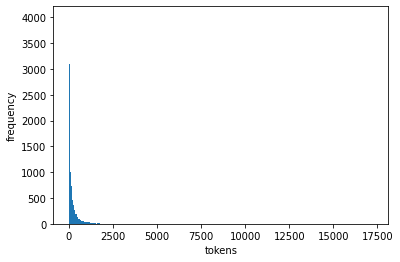

In [40]:
plt.hist(tokens_count, bins=500)
plt.ylabel('frequency')
plt.xlabel('tokens')
plt.show()

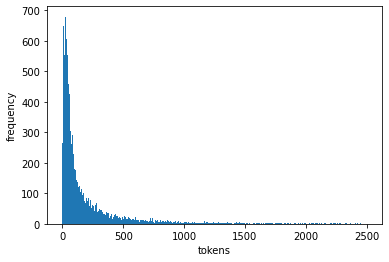

In [41]:
# "zooming in" to 0-2500 in x axis
plt.hist(tokens_count, bins=500, range=(-1, 2500))
plt.ylabel('frequency')
plt.xlabel('tokens')
plt.show()

In [42]:
tokens_count_df = pd.DataFrame(tokens_count)
tokens_count_df.describe()

,0
count,14871.000000
mean,202.430704
std,412.077454
min,1.000000
25%,33.000000
50%,75.000000
75%,210.000000
max,17250.000000


In [43]:
print(f"Number of articles that their number of words exceed the max_seq_length={bi_encoder.max_seq_length}\
 of the bi-encoder model: {len(tokens_count_df[tokens_count_df[0]>bi_encoder.max_seq_length])}/{len(tokens_count_df)}\
  ({len(tokens_count_df[tokens_count_df[0]>bi_encoder.max_seq_length])/len(tokens_count_df)*100}%)")


Number of articles that their number of words exceed the max_seq_length=512 of the bi-encoder model: 1457/14871  (9.79759262995091%)


### Keep 80% of data for training and 20% for evaluation of the model

In [44]:
from sklearn.model_selection import train_test_split
train_features, eval_features, train_labels, eval_labels = train_test_split(merged_glossary[['title','content']], 
                                                                            merged_glossary[['is_pair']], 
                                                                            train_size=0.8, 
                                                                            random_state=1,
                                                                            stratify=merged_glossary['is_pair'])

In [45]:
train_features = train_features.reset_index(drop=True)
eval_features = eval_features.reset_index(drop=True)

###Fine tuning bi-encoder (CUDA required)

In [46]:
# convert training examples to the appropriate format
train_examples = []
for i in range(len(train_features)):
  train_examples.append(InputExample(texts=[train_features['title'].iloc[i], train_features['content'].iloc[i]]))

In [47]:
finetune_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [48]:
# MultipleNegativesRankingLoss is a great loss function if you only have positive pairs 
loss = MultipleNegativesRankingLoss(model=bi_encoder)

In [49]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator, MSEEvaluator
from sentence_transformers import evaluation

sentences1 = list(eval_features['title'])
sentences2 = list(eval_features['content'])
scores_eval = list(eval_labels['is_pair'])

evaluator = evaluation.MSEEvaluator(sentences1, sentences2, teacher_model=bi_encoder)

In [50]:
#cleaning up any CUDA related left-overs
import gc
gc.collect()

36423

In [51]:
# Fine-tune the model (BE CAREFUL TO SET A PATH FOR THE FINE-TUNED MODEL)
bi_encoder.fit(train_objectives=[(finetune_dataloader, loss)], evaluator=evaluator, epochs=10,output_path='/content/drive/MyDrive/Data for Use Case C/testing_fine_tuning')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

Iteration:   0%|          | 0/744 [00:00<?, ?it/s]

###Loading the fine-tuned model

In [52]:
fine_tuned_bi_encoder = SentenceTransformer('/content/drive/MyDrive/Data for Use Case C/testing_fine_tuning')

In [53]:
bi_encoder = fine_tuned_bi_encoder

## Get results 

### Loading XML

In [54]:
MAX_DEPTH=20

## url = 'https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=table_of_contents.xml'

xml = lxml.etree.parse(XML_PATH)
elements_codes = xml.xpath(r'//nt:code',namespaces={'nt': 'urn:eu.europa.ec.eurostat.navtree'}) 
elements_names = xml.xpath(r'//nt:title[@language="en"]',namespaces={'nt': 'urn:eu.europa.ec.eurostat.navtree'}) 
elements_downloads = xml.xpath(r'//nt:downloadLink[@format="tsv"]',namespaces={'nt': 'urn:eu.europa.ec.eurostat.navtree'}) 
elements_downloads=[el.text for el in elements_downloads]
elements_files = [re.sub(r'\.tsv\.gz','',el).split('/')[-1] for el in elements_downloads]

In [55]:
crumbs_codes,crumb2,numbers,numbered_crumbs,crumbs_files = reduce_by_depth(elements_codes,elements_names)

import datetime
current_time = datetime.datetime.now() 
outfile = 'Crumbs_'+str(current_time.month)+ '_' + str(current_time.day) + '_' + str(current_time.hour)+ '_' + str(current_time.minute)  +'.xlsx'

crumbs_df = pd.DataFrame(numbered_crumbs,columns=['Number','Codes','Names','File code'])
idx = crumbs_df[crumbs_df['File code']==''].index
crumbs_df.drop(index=idx, inplace=True) 
crumbs_df.reset_index(inplace=True)


crumbs_df['Level'] = crumbs_df['Number'].apply(lambda x: x.count('.'))
crumbs_df['Names']=crumbs_df['Names'].apply(lambda x: x.split(';'))
crumbs_df['File description']=crumbs_df['Names'].apply(lambda x: x[-1])
crumbs_df['Codes']=crumbs_df['Codes'].apply(lambda x: x.split(';'))
crumbs_df = crumbs_df[['Number','Codes','Names','File description','File code','Level']]

crumbs_df['Full path'] = crumbs_df['Names'].apply(lambda x: [y for y in x[1:]]) ## exclude first part


###Adding Link info

In [56]:
for i in range(len(crumbs_df)):
  url='https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2F'+crumbs_df.loc[i,'File code']+'.tsv.gz'
  crumbs_df.loc[i,'Link'] = url

In [57]:
# Maybe drop duplicates with the same file code?
crumbs_df = crumbs_df.drop_duplicates(subset='File code', keep="first").reset_index()

###Calculate corpus embeddings in advance

In [58]:
# We encode all corpus into our vector space, using "File description" column. 
corpus_embeddings_simple = bi_encoder.encode(crumbs_df['File description'], convert_to_tensor=True, show_progress_bar=True)

# We encode all corpus into our vector space, using "Full path" column. 
corpus_embeddings_full = bi_encoder.encode(crumbs_df['Full path'], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/212 [00:00<?, ?it/s]

Batches:   0%|          | 0/212 [00:00<?, ?it/s]

In [59]:
#pre-download cross-encoder for re-ranking!
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

Downloading:   0%|          | 0.00/794 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Simple UI - Run once the chunk below then just change inputs

In [60]:
import eurostat

codes = {'hazard': 16, 'time': 1169, 'nace_r1': 888, 'geo': 4017, 
    'age691': None, 'rbd': 412, 'time1': None, 'nace_r2': 1298, 
    'worktime': 31, 'metroreg': 422, 'geo91': None, 'injury': 50, 'physact': 22, 'ceparema': 37, 
    'modinj': 11, 'train': 12, 'wrkenv': 15, 'frequenc': 61, 'tra_cov': 32, 'stk_flow': 190, 'par_mar': 302, 
    'currency': 193, 'cities': 13507, 'indic_env': 81, 'emp_cont': 17, 'loadstat': 3, 'size_emp': 31, 'airp_pr': 25160, 
    'unit': 668, 'nst07': 104, 'wat_proc': 56, 'comspec': 3, 'sex': 7, 'time91': None, 'age': 651, 
    'workproc': 9, 'age91': None, 'citizen': 4017, 'port_iww': 1032, 'source': 14, 'c_cabot': 4017, 
    'wrkstat': 5, 'c_birth': 4017, 'rep_airp': 1116, 'deviatn': 11, 'matagent': 23, 'diagnose': 28, 
    'rep_mar': 1842, 'partner': 4017, 'c_regis': 4017, 'geo1': None, 'seabasin': 12}

def relevant_datasets(query, corpus_embeddings,howmany,show_meta,show_meta_ind):

    # Encode query into our vector space 
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    top_k = 100  #Number of Eurostat databases we want to retrieve with the bi-encoder
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query
    hits_df = pd.DataFrame(hits)

    crumbs_df['corpus_id'] = crumbs_df.index
    hits_df1 = hits_df.merge(crumbs_df, on='corpus_id',how='left')
    hits_df1 = hits_df1[['corpus_id', 'score','File description', 'File code', 'Link']]

    #Re-ranking
    #Loading a cross-encoder model, and re-ranking the results of the bi-encoder
    #Cross-Encoder achieve higher performance than Bi-Encoders, however, they do not
    #scale well for large datasets. Here, it can make sense to combine Cross- and
    #Bi-Encoders, for Semantic Search scenarios: 
    #First, you use an efficient Bi-Encoder to retrieve e.g. the top-100 most
    #similar sentences for a query. Then, you use a Cross-Encoder to re-rank
    #these 100 hits by computing the score for every (query, hit) combination.

    a = hits_df1['File description']
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, a[hit]] for hit in range(len(hits_df1))]
    cross_scores = cross_encoder.predict(cross_inp)

    # sigmoid function 
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))
    # define vectorized sigmoid
    sigmoid_v = np.vectorize(sigmoid)
    cross_scores = sigmoid_v(cross_scores)

    hits_df1['cross_scores'] = cross_scores
    hits_df1 = hits_df1.sort_values(['cross_scores'],ascending=False).reset_index(drop=True)
    results = hits_df1[['corpus_id', 'cross_scores','File description', 'File code', 'Link']].head(howmany)

    hd = '<h3>Datasets descriptions in descending order of score - top '+str(howmany)+':</h3>'
    display(HTML(hd))
    display(HTML(results.to_html()))
    
    if show_meta:

        dst = pd.read_csv(results.loc[show_meta_ind,'Link'],sep='\t',low_memory=False)
        dcode=results.loc[show_meta_ind,'File code']
        dms = eurostat.get_sdmx_dims(dcode)
        h1 = '<h3>'+str(show_meta_ind)+': File code: '+dcode+'</h3>'
        h1 += '<h3>'+results.loc[show_meta_ind,'File description']+'</h3>'
        h1 += '<h3>Dimensions:</h3>'
        h1 += '  '.join('[' + x + ']' for x in dms)

        h2=''
        dims=dst.columns[0].split(',')
        dims = dims[:-1]+dims[-1].split('\\')
        
        tmp=dst.iloc[:,0].str.split(',',expand=True)

        for j in range(len(dims)-2): ## first the dimensions separated by comma
            if dims[j] not in codes.keys() or codes[dims[j]] != None:
                h2+='<h4>'+dims[j]+':</h4>'
                arr = pd.unique(tmp.iloc[:,j])
                for i in range(len(arr)):
                    h2+= '[ '+arr[i]+': '+eurostat.get_dic(dims[j])[arr[i]] +' ]'

        display(HTML(h1))
        display(HTML(h2))            
        display(HTML(dst.head().to_html()))

In [61]:
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import HTML, display,clear_output

layout = widgets.Layout(width='600px', height='60px')

In [62]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [63]:
def relevant_datasets_to_text(corpus_embeddings_full, corpus_embeddings_simple): 
    
    first_text = 'In 2021 unemployment among young people in Greece increased. This was the result of recession over the last 10 years.'  
    style = {'description_width': 'initial'}
    
    textW = widgets.Textarea(
        value=first_text, 
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='100px')
    )

    button = widgets.Button(description="Search")

    option = widgets.RadioButtons(
    options=['Simple description of datasets', 'Full-path description of datasets'],
    value='Full-path description of datasets', 
    layout={'width': 'max-content'}, 
    disabled=False
    )
    
    howmany = widgets.IntSlider(
        description='Display:',
        #tooltip='maximum:',
        value=20,
        min=1, 
        max = 30,
        style=style )
    howmany.style.handle_color = 'lightblue'
    
    show_more = widgets.Checkbox(
        value=True,
        description='Show metadata for row:',
        disabled=False,
        indent=True
     )
    
    select_ind = widgets.BoundedIntText(
        value=0,
        min=0,
        max=howmany.value-1,
        step=1,
        description='Row:',
        disabled=False,
        style={'description_width': 'initial'},
        layout = widgets.Layout(width='100px')
    )

    ui1=widgets.HBox([textW])
    ui2=widgets.HBox([option,button,howmany])
    ui3=widgets.HBox([show_more,select_ind])
    ui4=widgets.VBox([ui1,ui2,ui3])
    display(ui4, layout=Layout(align_items='center'))

    def on_button_clicked(b):
        clear_output()
        display(ui4, layout=Layout(align_items='center'))
        if option.value == 'Simple description of datasets':
            corpus_embeddings = corpus_embeddings_simple
        else:
          corpus_embeddings = corpus_embeddings_full
        relevant_datasets(textW.value,corpus_embeddings=corpus_embeddings, howmany=howmany.value,show_meta=show_more.value,show_meta_ind=select_ind.value)
       
    button.on_click(on_button_clicked)
    
    
relevant_datasets_to_text(corpus_embeddings_full, corpus_embeddings_simple)

,corpus_id,cross_scores,File description,File code,Link
0,1340,0.000674,Healthy life expectancy based on self-perceived health,hlth_silc_17,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fhlth_silc_17.tsv.gz
1,799,0.000181,Quality of education,med_ps24,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fmed_ps24.tsv.gz
2,5857,0.000084,Healthy life years at birth by sex,tps00150,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Ftps00150.tsv.gz
3,6597,0.000084,Healthy life years at birth by sex,sdg_03_11,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fsdg_03_11.tsv.gz
4,1187,0.000083,Life expectancy by age and sex,demo_mlexpec,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_mlexpec.tsv.gz
5,1338,0.000082,Healthy life years by sex (from 2004 onwards),hlth_hlye,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fhlth_hlye.tsv.gz
6,1339,0.000070,Healthy life years (1995 - 2003),hlth_hlye_h,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fhlth_hlye_h.tsv.gz
7,1186,0.000047,Life table by age and sex,demo_mlifetable,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_mlifetable.tsv.gz
8,1188,0.000046,"Life expectancy by age, sex and educational attainment level",demo_mlexpecedu,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_mlexpecedu.tsv.gz
9,5858,0.000037,Life expectancy at birth by sex,tps00208,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Ftps00208.tsv.gz


,"unit,indic_he,sex,geo\time",2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004
0,"YR,HE_50,F,AT",29.8,29.7,29.3,29.6,28.9,28.7,28.4,28.6,28.1,27.7,28.3,28.4,27.8,27.8,27.0,27.1
1,"YR,HE_50,F,BE",30.0 b,29.4,29.6,29.1,28.3,29.2,28.7,28.6,28.2,28.4,28.6,28.6,28.5,28.2,27.9,27.6
2,"YR,HE_50,F,BG",25.2,24.5,24.0,23.9 b,23.1,22.9,23.5,22.6,22.3,21.9,21.2,20.4,18.8,17.5,:,:
3,"YR,HE_50,F,CH",34.7,34.4,34.2,34.4,33.6,33.7,33.6,33.9,34.0,33.8,33.6,33.9,32.8,:,:,:
4,"YR,HE_50,F,CY",29.6,29.8,30.5,30.9,29.1,28.9,27.3,27.2,25.7,26.0,25.2,25.4,23.4,23.0,22.5,:
